In [5]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import spatial
from igl import igl
from local_global import local_global
from phasor import phasor
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
%matplotlib ipympl

In this notebook, we use the inplane projection proposed by Sifert et al, for the design of baromophes structures using phasor noise to create the channel pattern.


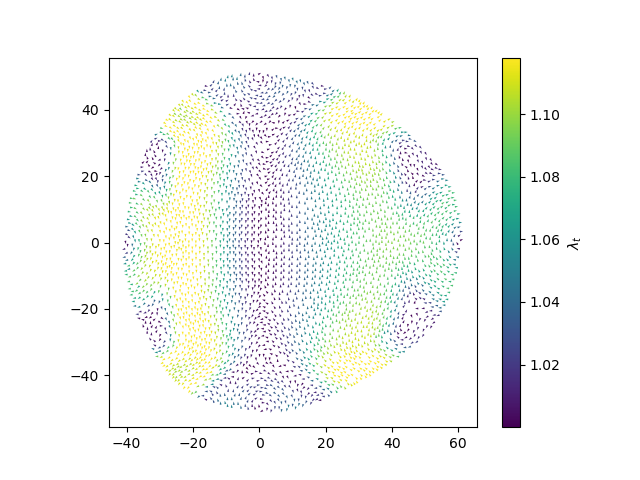

In [6]:
# Load the mesh and compute and create a in plane proyection u.
file_name = 'data/noise_surface.obj'
v,f = igl.read_triangle_mesh(file_name)
# for this particular case we take the proyection over the xy plane
u = v[:,:2].copy()
# for use the in plane proyection aproach we need to compute the gradient of the height.
grad = igl.grad(v,f) # discrete gradient operator
d_h = grad.dot(v[:,2]) # gradient of the hieght
d_h = np.reshape(d_h,(len(f),3), order = 'F') 
hx = d_h[:,0]
hy = d_h[:,1]
lmt = np.sqrt(1+hx**2+hy**2) # strech of the channels
ux = -hy/np.sqrt(hx**2+hy**2) # director field
uy = hx/np.sqrt(hx**2+hy**2)
p = u[f].mean(axis= 1)  # centers of the triangles

fig, axs = plt.subplots(1,1)
cs = axs.quiver(p[:,0],p[:,1],ux,uy,lmt)
cbar = fig.colorbar(cs,label = '$\lambda_t$')
axs.set_aspect('equal', 'box')
plt.show()

From this director field and scalar field $\lambda_t$ we will make a stripe pattern of periode $d$, for this we will use the phasors algorithm to create syntetic patterns. 

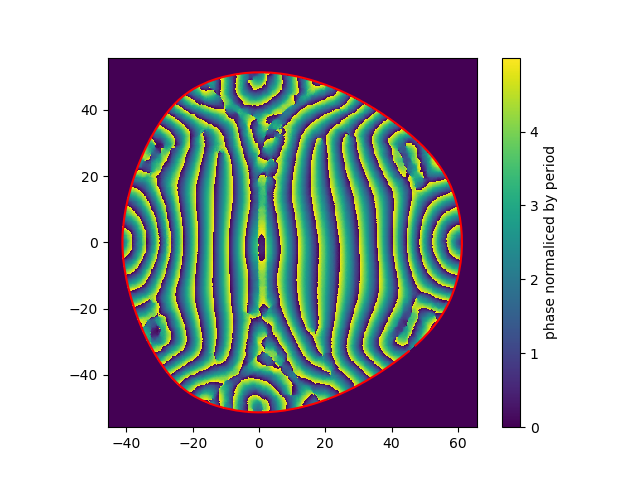

In [8]:
periode = 5.0
ulim = [p[:,0].min(),p[:,0].max()]
vlim = [p[:,1].min(),p[:,1].max()]
# create a grid of points with a density of half of the periode 
pu,pv = np.meshgrid(np.arange(ulim[0],ulim[1]+periode/2,periode/2),np.arange(vlim[0],vlim[1]+periode/2,periode/2))
phasor_centers = np.array([pu.flatten(),pv.flatten()]).T
# find the outline to exclude the point of the grid outside of the shape.
l = igl.boundary_loop(f)
poly = Polygon(u[l].tolist())
index =[poly.contains(Point(cen[0],cen[1])) for cen in phasor_centers]
phasor_centers = phasor_centers[index,:]
# create a tree to sample the direction on the created grid
tree = spatial.KDTree(p)
_,nieg = tree.query(phasor_centers,1)
phasor_direction = np.arctan2(uy[nieg],ux[nieg])
# cretate the phasor. 
ps = phasor()
ps.phase_sync = True
ps.phasor_compute(phasor_centers,phasor_direction+np.pi/2,1/periode,periode)
# create a evaluation grid with a higher density
subsampling = periode/20
xc,yc = np.meshgrid(np.arange(ulim[0]-periode,ulim[1]+periode,subsampling),np.arange(vlim[0]-periode,vlim[1]+periode,subsampling))
eval_centers = np.array([xc.flatten(),yc.flatten()]).T
index =np.array([poly.contains(Point(cen[0],cen[1])) for cen in eval_centers])
# eval the phasor noise in the evaluation grid
gabor = ps.eval(eval_centers,periode) # 
gabor = periode*(gabor+np.pi)/(2*np.pi)
gabor[~index] = 0.0
fig, axs = plt.subplots(1,1)
cs =axs.pcolor(xc,yc,gabor.reshape(xc.shape))
cbar = fig.colorbar(cs,label = 'phase normaliced by period')

# plot the boundary 
axs.plot(u[l,0],u[l,1],'-r')
axs.set_aspect('equal', 'box')
plt.show()

Until here we create the channel pattern but we should modulate the actual width of the channel in function $\lambda_t$. A reasonable approximation is $\lambda_t -1 \simeq \Phi\Psi p/E$, where p is the pressure and E is the youngs modulus of the material, the important quantities here are $\Phi$ and $\Psi$ the in-plane and out-of-plane densities respectively. 
From the geometry of the system $\Phi = \frac{d_c}{d}$ and $\Psi = \frac{h}{h+2e}$, and select the ratio $p/E = 0.2$ 


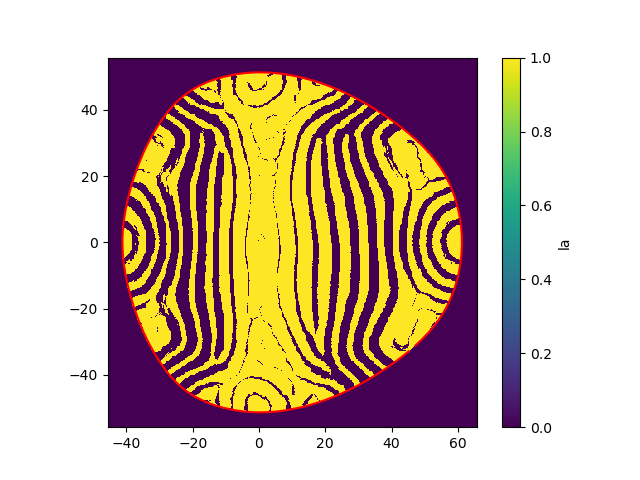

In [9]:
h = 4.0
e = 0.25 
ratio = 0.2
psi = h/(h+2*e)
_,nieg_eval = tree.query(eval_centers,1)
lam_t_in_centers = lmt[nieg_eval]
d_c = (lam_t_in_centers-1)*periode/(psi*ratio)
d_c[~index] = 0.0
pattern = gabor>d_c
fig, axs = plt.subplots(1,1)
cs =axs.pcolor(xc,yc,pattern.reshape(xc.shape))
cbar = fig.colorbar(cs,label = 'la')

axs.plot(u[l,0],u[l,1],'-r')
axs.set_aspect('equal', 'box')
plt.show()